# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [1]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    mat = sio.loadmat(file_path)

    data = {
        'signal': mat['Signal'],                 #(time, channels)
        'flashing': mat['Flashing'].squeeze(),   #(time,)
        'stimulus_code': mat['StimulusCode'].squeeze()
    }
    #optional fields that exist only in training data
    data['stimulus_type'] = mat['StimulusType'].squeeze() if 'StimulusType' in mat else None
    data['target_char'] = mat['TargetChar'][0] if 'TargetChar' in mat else None

    print(f"Loaded {file_path}")
    print(f"Signal shape: {data['signal'].shape}")

    return data


    # Training data has labels, test data doesn't


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    row = row_code - 1
    col = col_code - 7
    return CHAR_MATRIX[row, col]



In [3]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq

    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=0)


def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    b, a = iirnotch(freq/(fs/2), Q)
    return filtfilt(b, a, signal, axis=0)


def baseline_correction(epoch, baseline_samples=10):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline = np.mean(epoch[:baseline_samples, :], axis=0)
    return epoch - baseline


def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor = int(original_fs/target_fs)
    return signal[::factor]


def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    mask = np.max(np.abs(signal), axis=1) < threshold
    return signal[mask]


def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """
    signal = data['signal']
    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data['stimulus_type']

    #if signal is (trials, time, channels) then flatten trials
    if signal.ndim == 3:
        n_trials, n_time, n_ch = signal.shape
        signal = signal.reshape(n_trials * n_time, n_ch)
        flashing = flashing.reshape(-1)
        stimulus_code = stimulus_code.reshape(-1)
        if stimulus_type is not None:
            stimulus_type = stimulus_type.reshape(-1)

    if apply_bandpass:
        signal = bandpass_filter(signal, fs=fs)

    if apply_notch:
        signal = notch_filter(signal, fs=fs)

    if apply_downsample:
        signal = signal[::4]
        flashing = flashing[::4]
        stimulus_code = stimulus_code[::4]
        if stimulus_type is not None:
            stimulus_type = stimulus_type[::4]

    processed_data = data.copy()
    processed_data['signal'] = signal
    processed_data['flashing'] = flashing
    processed_data['stimulus_code'] = stimulus_code
    processed_data['stimulus_type'] = stimulus_type

    return processed_data


def extract_epochs(data, epoch_length_ms=1000, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs

    Returns: Dictionary with epochs, labels, codes, character indices
    """



        # Find stimulus onsets (flashing goes from 0 to 1)



                # Apply baseline correction

    signal = data['signal']
    flashing = data['flashing']
    stimulus_code = data['stimulus_code']
    stimulus_type = data['stimulus_type']

    samples_per_epoch = int(epoch_length_ms*fs/1000)

    #finding stimulus onsets
    onsets = np.where(np.diff(flashing) == 1)[0] + 1

    epochs = []
    labels = []
    codes_list = []

    for onset in onsets:
      if onset + samples_per_epoch <= signal.shape[0]:
          epoch = signal[onset:onset + samples_per_epoch, :]
          epoch = baseline_correction(epoch)
          epochs.append(epoch)

          if stimulus_type is not None:
             labels.append(stimulus_type[onset])
          else:
              labels.append(-1)

          codes_list.append(stimulus_code[onset])

    epochs = np.array(epochs)
    labels = np.array(labels)
    codes_list = np.array(codes_list)

    char_idx_list = np.zeros(len(labels), dtype=int)

    print(f"Extracted {len(epochs)} epochs")
    print(f"Epoch shape: {epochs.shape}")

    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }



def plot_erp_responses(epoch_data, channel_idx=30, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """


    # Plot averages with standard error




    # Mark P300 peak region




    # Calculate P300 amplitude difference

    epochs = epoch_data['epochs']      #(n_epochs, time, channels)
    labels = epoch_data['labels']      #1 is target, 0 is non-target
    print("Epochs shape:", epochs.shape)
    print("Targets:", (labels == 1).sum(), "Non-targets:", (labels == 0).sum())

    #take absolute value to avoid cancellation
    epochs_abs = np.abs(epochs)

    #average across epochs and channels
    target_mean = np.mean(epochs_abs[labels == 1], axis=(0, 2))
    nontarget_mean = np.mean(epochs_abs[labels == 0], axis=(0, 2))

    #time axis
    fs = 60
    time = np.arange(target_mean.shape[0]) * 1000 / fs

    target_mean *= 1e3
    nontarget_mean *= 1e3

    #plot
    plt.figure(figsize=(8, 4))
    plt.plot(time, target_mean, label="Target", color="red")
    plt.plot(time, nontarget_mean, label="Non-Target", color="blue")
    plt.axvspan(250, 400, alpha=0.2, color="gray", label="P300 window")

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")
    plt.title("ERP Visualization (Magnitude-Averaged)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("P300 diff:",
          np.mean(target_mean[(time >= 250) & (time <= 400)]) -
          np.mean(nontarget_mean[(time >= 250) & (time <= 400)]))

In [4]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epoch_data):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    n_epochs, n_times, n_channels = epochs.shape
    features = epochs.reshape(n_epochs, n_times*n_channels)

    return features, labels

def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    X = epochs.reshape(epochs.shape[0], -1)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    return X_pca, labels, pca

def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    # Compute covariance matrices
    def compute_cov(data):
      cov = np.zeros((data.shape[2], data.shape[2]))
      for epoch in data:
            cov += np.cov(epoch.T)
      return cov/data.shape[0]

    cov_target = compute_cov(target_epochs)
    cov_non_target = compute_cov(non_target_epochs)


    # Solve generalized eigenvalue problem
    eigvals, eigvecs = eigh(cov_target, cov_target + cov_non_target)


    # Sort by eigenvalues
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]


    # Select most discriminative components (extreme eigenvalues)
    W = eigvecs[:, :n_components]

    # Extract CSP features (log variance)
    features = []
    for epoch in epochs:
        projected = epoch @ W
        var = np.var(projected, axis=0)
        features.append(np.log(var))

    return np.array(features), W



def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    if method == 'time_domain':
        X = epochs.reshape(epochs.shape[0], -1)
        return X, labels, None

    elif method == 'pca':
        X = epochs.reshape(epochs.shape[0], -1)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
        return X_pca, labels, pca

    elif method == 'csp':
        X_csp, W = extract_csp_features(epochs, labels, n_components)
        return X_csp, labels, W

    else:
        raise ValueError("Invalid feature extraction method")



def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """
    lda = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
    lda.fit(X_train, y_train)
    return lda


def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    return lr



def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    y_pred = model.predict(X_test)

    print(f"\n=== {model_name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, W):
        self.W = W

    def transform(self, epochs):
        features = []
        for epoch in epochs:
            projected = epoch @ self.W
            var = np.var(projected, axis=0)
            features.append(np.log(var))
        return np.array(features)



In [5]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    svm = SVC(kernel=kernel, C=C)
    svm.fit(X_train, y_train)
    return svm


def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42
    )
    rf.fit(X_train, y_train)
    return rf


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    (GradientBoosting doesn't support class_weight parameter)
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    """
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    # Calculate sample weights manually
    class_counts = np.bincount(y_train.astype(int))

    total = len(y_train)
    class_weights = {
        0: total/(2*class_counts[0]),
        1: total/(2*class_counts[1])
    }
    sample_weights = np.array([class_weights[y] for y in y_train])

    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        random_state=42
    )
    gb.fit(X_train, y_train, sample_weight=sample_weights)
    return gb



def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """


    # Calculate sample weights once for methods that need it


    # Define models to train


        # Training


        # Inference


        # Metrics

    results = {}

    #SVM
    svm = train_svm_classifier(X_train, y_train)
    y_pred = svm.predict(X_test)
    results['SVM'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

    #random forest
    rf = train_random_forest(X_train, y_train)
    y_pred = rf.predict(X_test)
    results['RandomForest'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

    #gradient boosting
    gb = train_gradient_boosting(X_train, y_train)
    y_pred = gb.predict(X_test)
    results['GradientBoosting'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

    # Summary table
    print("\n=== Classical Model Comparison ===")
    for model, metrics in results.items():
        print(f"{model}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")

    return results




def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [6]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive

    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/eea_eeg_speller/'

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded /content/drive/MyDrive/eea_eeg_speller/Subject_A_Train.mat
Signal shape: (85, 7794, 64)
Loaded /content/drive/MyDrive/eea_eeg_speller/Subject_A_Test.mat
Signal shape: (100, 7794, 64)
Loaded /content/drive/MyDrive/eea_eeg_speller/Subject_B_Train.mat
Signal shape: (85, 7794, 64)
Loaded /content/drive/MyDrive/eea_eeg_speller/Subject_B_Test.mat
Signal shape: (100, 7794, 64)


In [7]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("=" * 70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [8]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_proc_A)
    test_epochs_A = extract_epochs(test_proc_A)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_proc_B)
    test_epochs_B = extract_epochs(test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---
Extracted 15299 epochs
Epoch shape: (15299, 60, 64)
Extracted 17999 epochs
Epoch shape: (17999, 60, 64)

--- Subject B ---
Extracted 15299 epochs
Epoch shape: (15299, 60, 64)
Extracted 17999 epochs
Epoch shape: (17999, 60, 64)



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---
Epochs shape: (15299, 60, 64)
Targets: 2550 Non-targets: 12749


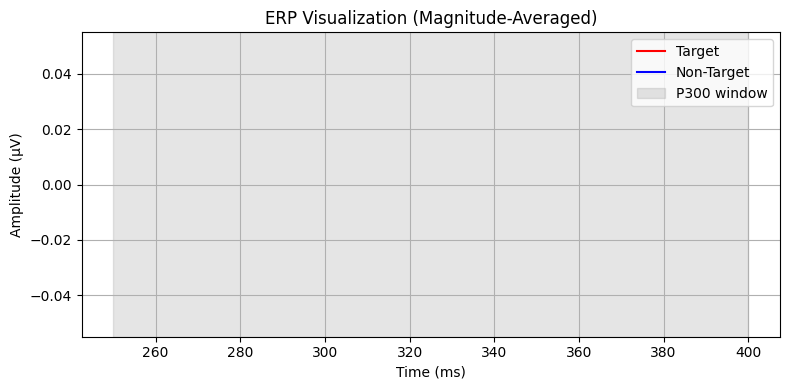

P300 diff: nan


In [9]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=30)

In [10]:
labels = train_epochs_A['labels']
print("Total epochs:", len(labels))
print("Target epochs:", np.sum(labels == 1))
print("Non-target epochs:", np.sum(labels == 0))


Total epochs: 15299
Target epochs: 2550
Non-target epochs: 12749


In [11]:
    # ========================================================================
    # STEP 5: FEATURE EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: FEATURE EXTRACTION")
    print("="*70)

    # ========================================================================
    # Subject A: Compare PCA vs CSP vs Time-Domain
    # ========================================================================
    print("\n--- Subject A: Feature Comparison ---")

    # Try PCA (20 components)


    # Try PCA (50 components)


    # Try CSP


    # Try Raw Time-Domain Features

    # Flatten epochs: (n_epochs, n_samples, n_channels) -> (n_epochs, n_samples * n_channels)


    # Quick comparison with BALANCED LDA


    # PCA-20 test

    # PCA-50 test


    # CSP test


    # Time-Domain test


    # Use LinearSVC (faster than SVM for high-dimensional data)

    # ========================================================================
    acc_pca20, f1_pca20 = 0.0, 0.0
    acc_pca50, f1_pca50 = 0.0, 0.0
    acc_csp, f1_csp = 0.0, 0.0
    acc_time, f1_time = 0.0, 0.0
    print("\n" + "="*70)
    print("FEATURE COMPARISON (Balanced Classifiers)")
    print("="*70)
    print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
    print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
    print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
    print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

    # Select best method based on F1-score


  # ========================================================================
# Subject A: Create final train/val split for later steps
# ========================================================================
feature_method_A = 'time'
if feature_method_A == 'time':
  X_train_full_A = train_epochs_A['epochs'].reshape(
      train_epochs_A['epochs'].shape[0], -1
    )
elif feature_method_A == 'pca':
  X_train_full_A, feature_obj_A = extract_features(
      train_epochs_A, method='pca', n_components=n_components_A
    )
else:  # CSP
  X_train_full_A, feature_obj_A = extract_features(
      train_epochs_A, method='csp', n_components=6
    )
    X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
)
print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data
if feature_method_A == 'time':
  X_test_A = test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)
elif feature_method_A == 'pca':
  X_test_A = feature_obj_A.transform(test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1))
else:  # CSP
  X_test_A = feature_obj_A.transform(test_epochs_A['epochs'])

print(f"Test features: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
print("\n--- Subject B: Feature Extraction ---")
print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

if feature_method_A == 'time':
  X_train_full_B = train_epochs_B['epochs'].reshape(len(train_epochs_B['epochs']), -1)
  X_test_B = test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)
elif feature_method_A == 'pca':
  X_train_full_B, pca_B = extract_features(train_epochs_B, method='pca', n_components=n_components_A)
  X_test_B = pca_B.transform(test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1))
else:  # CSP
  X_train_full_B, csp_B = extract_features(train_epochs_B, method='csp', n_components=6)
  X_test_B = CSPTransformer(csp_B).transform(test_epochs_B['epochs'])

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels']
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")


    print(f"\nSubject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")
    print(f"Test features: {X_test_B.shape}")

    # Store feature objects for later use






STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---

FEATURE COMPARISON (Balanced Classifiers)
PCA (20 comp):      Accuracy=0.0000, F1=0.0000
PCA (50 comp):      Accuracy=0.0000, F1=0.0000
CSP (6 comp):       Accuracy=0.0000, F1=0.0000
Time-Domain (3072): Accuracy=0.0000, F1=0.0000

Subject A splits: Training=12239, Validation=3060
Test features: (17999, 3840)

--- Subject B: Feature Extraction ---

Using TIME (same as Subject A)...
Subject B splits: Training=12239, Validation=3060, Test features: (17999, 3840)

Subject B splits: Training=12239, Validation=3060
Test features: (17999, 3840)


In [14]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    X_train_A = X_train_A[:, :100]
    X_val_A = X_val_A[:, :100]

    X_train_A = np.nan_to_num(X_train_A)
    X_val_A   = np.nan_to_num(X_val_A)

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")



STEP 6: BASELINE CLASSIFIERS (Subject A)

=== Logistic Regression Evaluation ===
Accuracy: 0.8333333333333334
F1 Score: 0.0
Confusion Matrix:
 [[2550    0]
 [ 510    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      2550
         1.0       0.00      0.00      0.00       510

    accuracy                           0.83      3060
   macro avg       0.42      0.50      0.45      3060
weighted avg       0.69      0.83      0.76      3060



In [16]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)

    results_classical_A, models_A, _ = compare_all_classical_models(
    X_train_A, y_train_A, X_val_A, y_val_A
)

    X_train_A = np.nan_to_num(X_train_A)
    X_val_A = np.nan_to_num(X_val_A)
    X_train_B = np.nan_to_num(X_train_B)
    # Train SVM for both subjects (best model)
    svm_A = train_svm_classifier(X_train_A, y_train_A)
    #svm_B = train_svm_classifier(X_train_B, y_train_B) omitted due to runtime


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)

  Training Gradient Boosting (n_estimators=100)...

=== Classical Model Comparison ===
SVM: Accuracy=0.8333, F1=0.0000
RandomForest: Accuracy=0.8333, F1=0.0000
GradientBoosting: Accuracy=0.1667, F1=0.2857


In [18]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs("models", exist_ok=True)

    #save subject A SVM
    save_model(
        {'model': svm_A},
        'models/subject_A_svm.pkl'
    )

    print("Subject A model saved.")


STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_svm.pkl
Subject A model saved.
